In [130]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import mlflow
import mlflow.sklearn

In [4]:
df = pd.read_csv("./Data/insurance_data.csv")
df.head(3)

,Policy_ID,Customer_Age,Gender,Policy_Type,Annual_Income,Claim_History,Fraudulent_Claim,Premium_Amount,Claim_Amount,Risk_Score
0,POL000001,56,M,Life,111642,0,0,828.63,0.0,Low
1,POL000002,69,M,Auto,42853,0,0,1767.80,0.0,Medium
2,POL000003,46,F,Life,135705,1,0,981.47,63156.4,Low


In [5]:
df.shape

(9000, 10)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Policy_ID         9000 non-null   object 
 1   Customer_Age      9000 non-null   int64  
 2   Gender            9000 non-null   object 
 3   Policy_Type       9000 non-null   object 
 4   Annual_Income     9000 non-null   int64  
 5   Claim_History     9000 non-null   int64  
 6   Fraudulent_Claim  9000 non-null   int64  
 7   Premium_Amount    9000 non-null   float64
 8   Claim_Amount      9000 non-null   float64
 9   Risk_Score        9000 non-null   object 
dtypes: float64(2), int64(4), object(4)
memory usage: 703.3+ KB


# Data Processing

### Check for Null Values and Duplicate Value

In [7]:
df.isna().sum()

Policy_ID           0
Customer_Age        0
Gender              0
Policy_Type         0
Annual_Income       0
Claim_History       0
Fraudulent_Claim    0
Premium_Amount      0
Claim_Amount        0
Risk_Score          0
dtype: int64

In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
df.describe()

,Customer_Age,Annual_Income,Claim_History,Fraudulent_Claim,Premium_Amount,Claim_Amount
count,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000
mean,49.374889,67474.012222,0.644111,0.007778,1634.803796,4558.764674
std,18.163018,33847.070509,1.027735,0.087853,864.246423,10401.246718
min,18.000000,20000.000000,0.000000,0.000000,340.000000,0.000000
25%,34.000000,42975.500000,0.000000,0.000000,1083.895000,0.000000
50%,49.000000,60021.000000,0.000000,0.000000,1346.420000,0.000000
75%,65.000000,83827.250000,1.000000,0.000000,1910.472500,5536.895000
max,80.000000,200000.000000,5.000000,1.000000,6866.320000,283761.080000


# Exploratory Data Analysis

## Univariate Analysis - Numerical Columns

In [10]:
numeric_columns = df.select_dtypes(include=['float64','int64']).columns
numeric_columns

Index(['Customer_Age', 'Annual_Income', 'Claim_History', 'Fraudulent_Claim',
       'Premium_Amount', 'Claim_Amount'],
      dtype='object')

### Boxplot Analysis of Numerical Columns

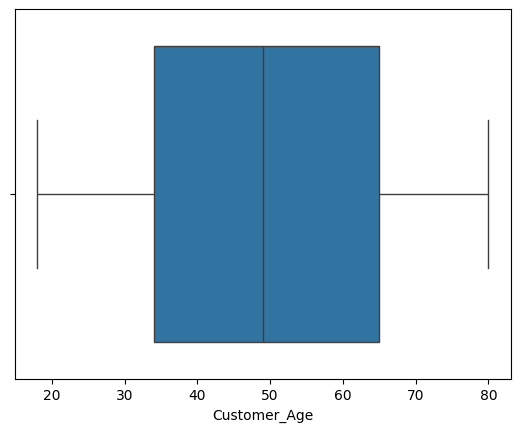

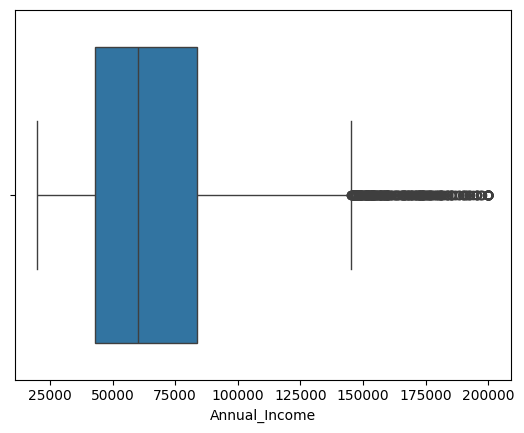

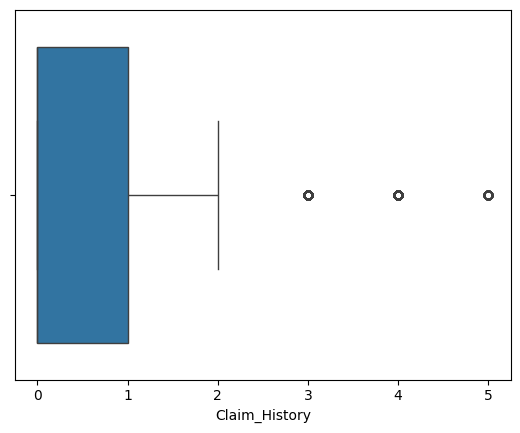

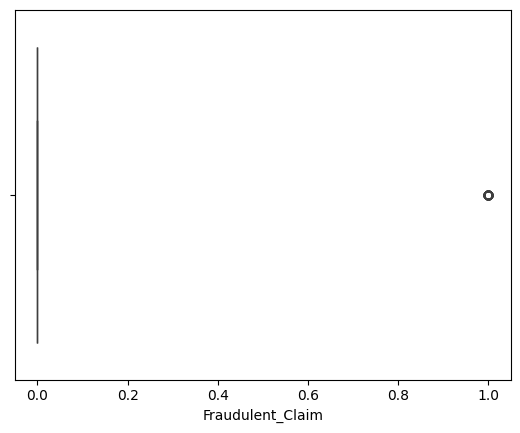

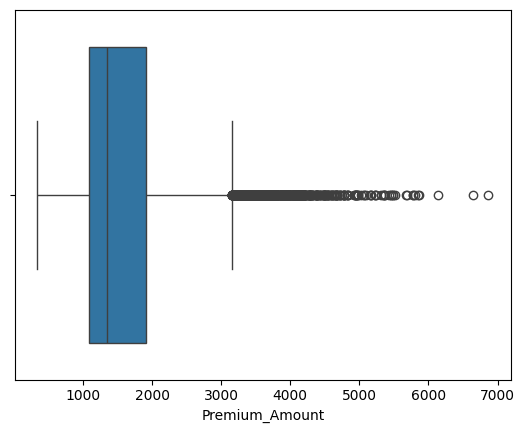

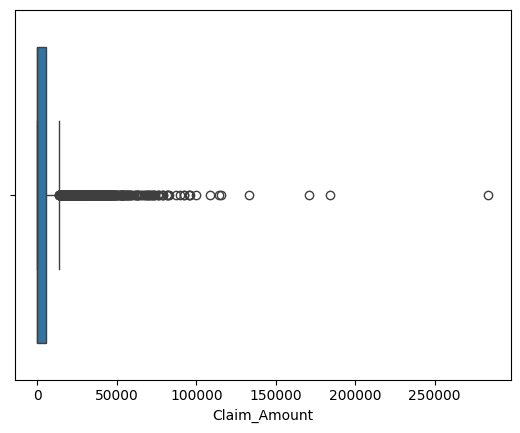

In [11]:
for col in numeric_columns:
    sns.boxplot(df, x=col)
    plt.show()

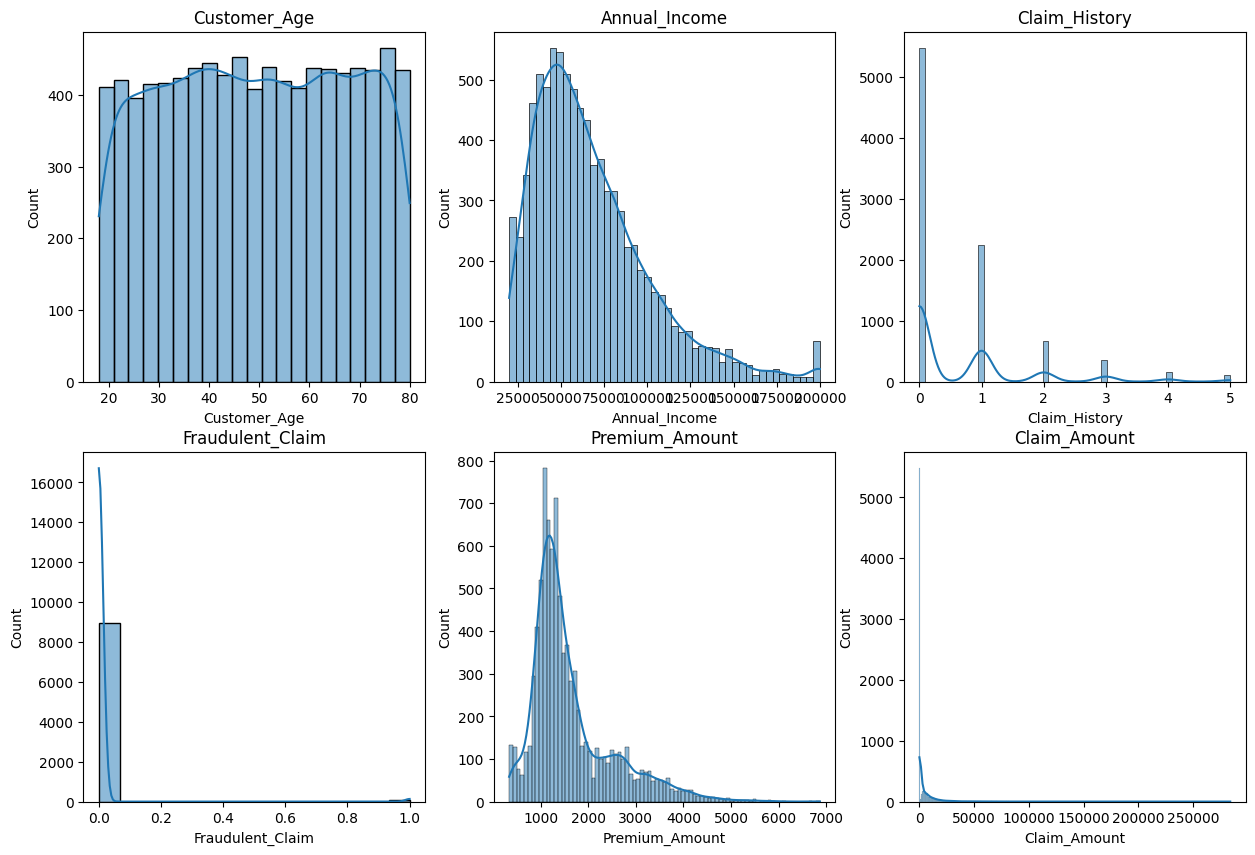

In [12]:
n_cols = 3  # number of columns in the subplot grid
n_rows = (len(numeric_columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, column in enumerate(numeric_columns):
    sns.histplot(df[column], kde=True, ax=axes[i])
    axes[i].set_title(column)

### Remove Outliers from Claim_Amount

In [13]:
column_name = 'Claim_Amount'

# Step 1: Calculate IQR
Q1 = df[column_name].quantile(0.25)
Q3 = df[column_name].quantile(0.75)
IQR = Q3 - Q1

# Step 2: Define outlier bounds (typically 1.5 * IQR beyond Q1 and Q3)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 3: Create a mask for outliers
outlier_mask = (df[column_name] < lower_bound) | (df[column_name] > upper_bound)

# Step 4: Show the outlier values
outlier_values = df.loc[outlier_mask, column_name]
print(f"Number of outliers detected: {len(outlier_values)}")
print(f"Outlier bounds: {lower_bound} to {upper_bound}")
print("\nOutlier values:")
print(outlier_values.sort_values())

# Step 5: Remove the outliers
df_clean = df[~outlier_mask].copy()
print(f"\nOriginal dataframe shape: {df.shape}")
print(f"Dataframe shape after removing outliers: {df_clean.shape}")
print(f"Removed {outlier_mask.sum()} rows ({outlier_mask.mean()*100:.2f}% of data)")

# Step 6: Compare statistics before and after
print("\nBefore removing outliers:")
print(df[column_name].describe())
print("\nAfter removing outliers:")
print(df_clean[column_name].describe())

Number of outliers detected: 876
Outlier bounds: -8305.342499999999 to 13842.2375

Outlier values:
3011     13869.60
453      13882.53
606      13889.54
890      13926.38
5466     13937.37
          ...    
4882    115688.00
8595    133174.11
5819    170879.90
636     184057.67
4794    283761.08
Name: Claim_Amount, Length: 876, dtype: float64

Original dataframe shape: (9000, 10)
Dataframe shape after removing outliers: (8124, 10)
Removed 876 rows (9.73% of data)

Before removing outliers:
count      9000.000000
mean       4558.764674
std       10401.246718
min           0.000000
25%           0.000000
50%           0.000000
75%        5536.895000
max      283761.080000
Name: Claim_Amount, dtype: float64

After removing outliers:
count     8124.000000
mean      2024.940794
std       3491.235336
min          0.000000
25%          0.000000
50%          0.000000
75%       3270.092500
max      13839.030000
Name: Claim_Amount, dtype: float64


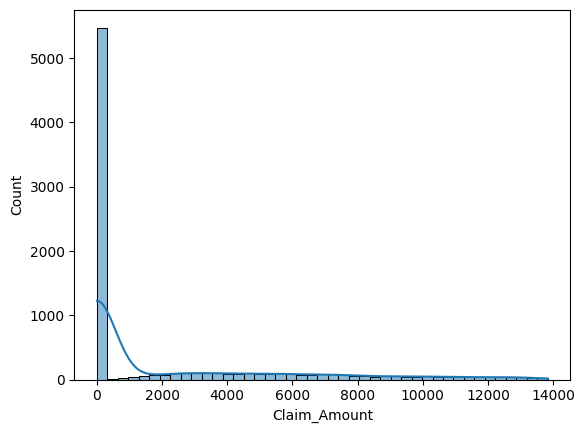

In [14]:
sns.histplot(df_clean['Claim_Amount'], kde=True)
plt.show()

### Bivariate Analysis - Numerical Columns

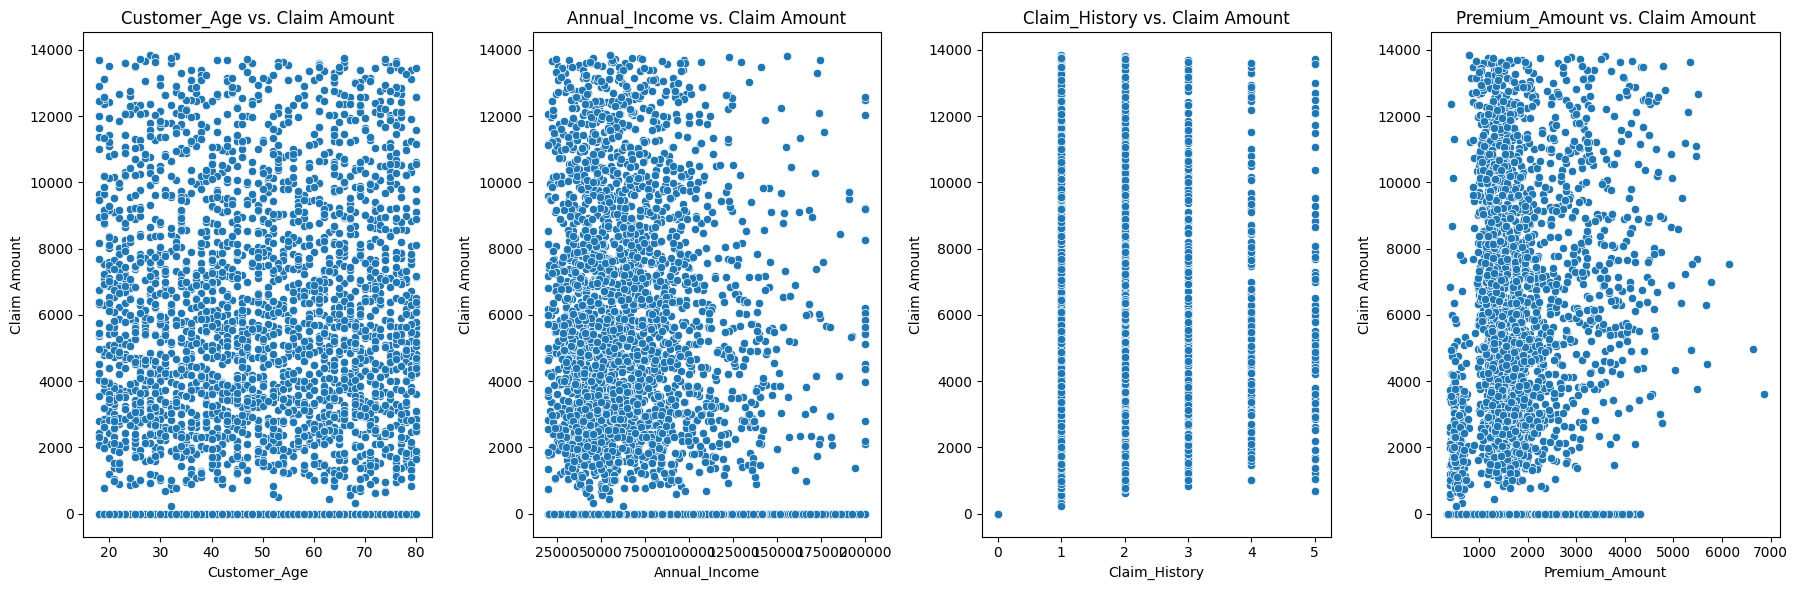

In [15]:
numeric_features = ['Customer_Age', 'Annual_Income', 'Claim_History', 'Premium_Amount']

fig, axes = plt.subplots(1, len(numeric_features), figsize=(18, 6))  # Adjust figure size as necessary

for ax, column in zip(axes, numeric_features):
    sns.scatterplot(x=df_clean[column], y=df_clean['Claim_Amount'], ax=ax)
    ax.set_title(f'{column} vs. Claim Amount')
    ax.set_xlabel(column)
    ax.set_ylabel('Claim Amount')

plt.tight_layout()  # Adjust layout
plt.show()

## Categorical Columns - Analysis

### Univariate - Categorical Columns

In [16]:
df_clean.dtypes

Policy_ID            object
Customer_Age          int64
Gender               object
Policy_Type          object
Annual_Income         int64
Claim_History         int64
Fraudulent_Claim      int64
Premium_Amount      float64
Claim_Amount        float64
Risk_Score           object
dtype: object

In [17]:
categorical_cols = df_clean.select_dtypes(include = ['object']).columns
categorical_cols

Index(['Policy_ID', 'Gender', 'Policy_Type', 'Risk_Score'], dtype='object')

In [18]:
categorical_cols = ['Gender', 'Policy_Type', 'Risk_Score']

In [19]:
for col in categorical_cols:
    print(col, ":", df_clean[col].unique())

Gender : ['M' 'F']
Policy_Type : ['Life' 'Auto' 'Home' 'Health' 'Travel']
Risk_Score : ['Low' 'Medium' 'High']


In [20]:
pct_count = df_clean['Gender'].value_counts(normalize=True)*100
pct_count

Gender
M    50.393895
F    49.606105
Name: proportion, dtype: float64

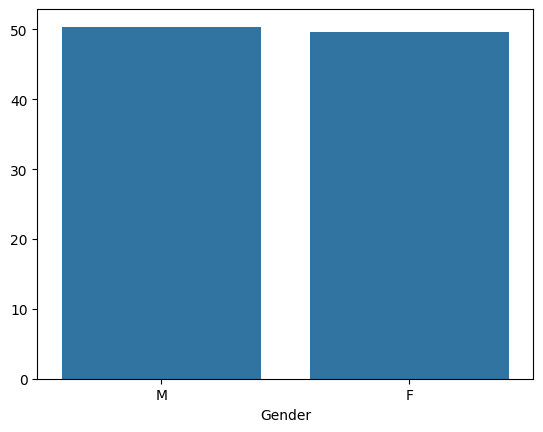

In [21]:
sns.barplot(x= pct_count.index, y=pct_count.values)
plt.show()

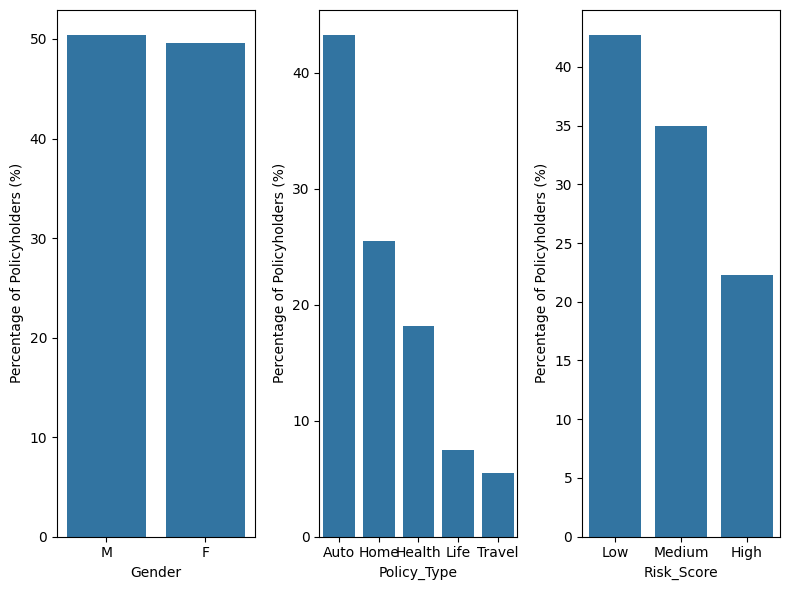

In [70]:
fig, axes = plt.subplots(1, 3, figsize=(8, 6))  # Adjust figure size as necessary
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for ax, column in zip(axes, categorical_cols):
    # Calculate the percentage distribution of each category
    category_counts = df_clean[column].value_counts(normalize=True) * 100  # normalize=True gives the relative frequencies
    
    # Plotting the distribution using barplot
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax)
    #ax.set_title(f'Percentage Distribution of {column}')
    ax.set_ylabel('Percentage of Policyholders (%)')
    ax.set_xlabel(column) # Set xlabel to the column name for clarity
        

plt.tight_layout()  # Adjusts plot parameters for better fit in the figure window
plt.show()

### Bivariate - Categorical Columns

In [23]:
cross_tab =  pd.crosstab(df_clean['Policy_Type'], df_clean['Risk_Score'])
print(cross_tab)

Risk_Score   High   Low  Medium
Policy_Type                    
Auto          831  1447    1236
Health        290   668     520
Home          486   866     722
Life           76   315     219
Travel        127   174     147


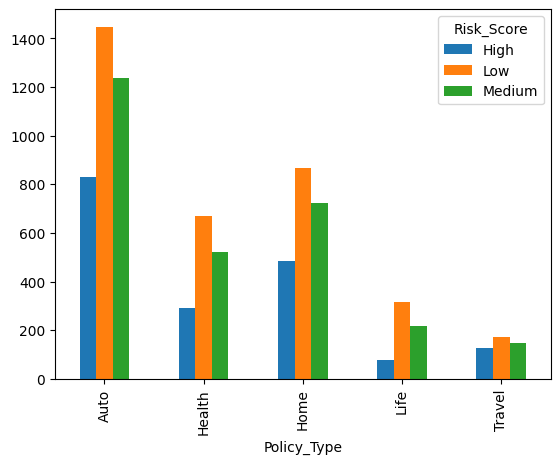

In [24]:
cross_tab.plot(kind='bar')
plt.show()

In [25]:
cross_tab =  pd.crosstab(df_clean['Policy_Type'], df_clean['Fraudulent_Claim'])
print(cross_tab)

Fraudulent_Claim     0   1
Policy_Type               
Auto              3495  19
Health            1473   5
Home              2064  10
Life               609   1
Travel             442   6


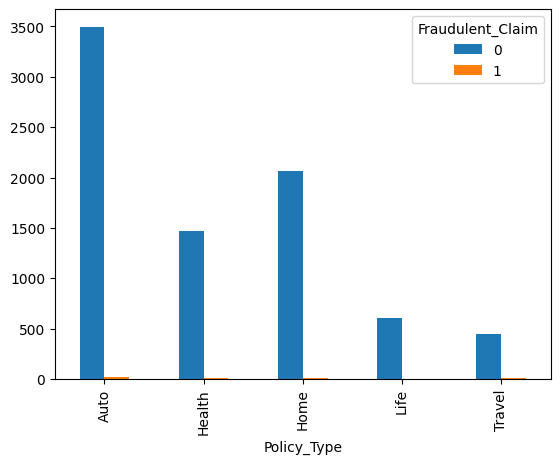

In [26]:
cross_tab.plot(kind='bar')
plt.show()

# Feature Engineering

### Encoding Categorical Data
1. One-Hot Encoding for Policy_Type, Gender.
2. Label Encoding for Risk_Score (Low → 0, Medium → 1, High → 2).

In [27]:
df_train = pd.get_dummies(df_clean, columns=['Policy_Type', 'Gender'], drop_first=True, dtype=int)

In [28]:
df_train.head(3)

,Policy_ID,Customer_Age,Annual_Income,Claim_History,Fraudulent_Claim,Premium_Amount,Claim_Amount,Risk_Score,Policy_Type_Health,Policy_Type_Home,Policy_Type_Life,Policy_Type_Travel,Gender_M
0,POL000001,56,111642,0,0,828.63,0.0,Low,0,0,1,0,1
1,POL000002,69,42853,0,0,1767.80,0.0,Medium,0,0,0,0,1
3,POL000004,32,43703,0,0,1097.23,0.0,Low,0,0,0,0,1


In [29]:
df_train['Risk_Score'] = df_train['Risk_Score'].map({ 'Low':0, 'Medium': 1, 'High': 2})


In [30]:
df_train = df_train.drop('Policy_ID', axis=1) # drop the Policy_ID column to train the model

In [31]:
df_train.head(3)

,Customer_Age,Annual_Income,Claim_History,Fraudulent_Claim,Premium_Amount,Claim_Amount,Risk_Score,Policy_Type_Health,Policy_Type_Home,Policy_Type_Life,Policy_Type_Travel,Gender_M
0,56,111642,0,0,828.63,0.0,0,0,0,1,0,1
1,69,42853,0,0,1767.80,0.0,1,0,0,0,0,1
3,32,43703,0,0,1097.23,0.0,0,0,0,0,0,1


### Feature Scaling - Normalize numerical features 'Annual_Income, Claim_Amount, Premium_Amount' using MinMaxScale

In [32]:
cols_to_scale = ['Annual_Income', 'Premium_Amount', 'Claim_Amount']
scaler = MinMaxScaler()
df_train[cols_to_scale] = scaler.fit_transform(df_train[cols_to_scale])
df_train.describe()

,Customer_Age,Annual_Income,Claim_History,Fraudulent_Claim,Premium_Amount,Claim_Amount,Risk_Score,Policy_Type_Health,Policy_Type_Home,Policy_Type_Life,Policy_Type_Travel,Gender_M
count,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000
mean,49.370261,0.262842,0.530650,0.005047,0.192121,0.146321,0.795667,0.181930,0.255293,0.075086,0.055145,0.503939
std,18.255522,0.187811,0.958152,0.070866,0.125536,0.252275,0.779903,0.385811,0.436053,0.263547,0.228278,0.500015
min,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34.000000,0.126608,0.000000,0.000000,0.113479,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,49.000000,0.221022,0.000000,0.000000,0.152797,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,65.000000,0.354654,1.000000,0.000000,0.229120,0.236295,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,80.000000,1.000000,5.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Fraud Detection: Anomaly Tagging - Isolation Forest

In [33]:
from sklearn.ensemble import IsolationForest

# Select relevant features
features = ['Annual_Income', 'Premium_Amount', 'Claim_Amount']
X = df_train[features]

# Train Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
df_train['IF_Anomaly_Score'] = iso_forest.fit_predict(X)

# Tag anomalies (where prediction is -1)
df_train['IF_Anomaly_Tag'] = df_train['IF_Anomaly_Score'].map({1: 0, -1: 1})  # 1 = Anomaly

In [34]:
df_train.head(3)

,Customer_Age,Annual_Income,Claim_History,Fraudulent_Claim,Premium_Amount,Claim_Amount,Risk_Score,Policy_Type_Health,Policy_Type_Home,Policy_Type_Life,Policy_Type_Travel,Gender_M,IF_Anomaly_Score,IF_Anomaly_Tag
0,56,0.509122,0,0,0.074871,0.0,0,0,0,1,0,1,1,0
1,69,0.126961,0,0,0.218776,0.0,1,0,0,0,0,1,1,0
3,32,0.131683,0,0,0.116027,0.0,0,0,0,0,0,1,1,0


In [35]:
df_train['IF_Anomaly_Tag'].value_counts()

IF_Anomaly_Tag
0    7717
1     407
Name: count, dtype: int64

In [36]:
cross_tab =  pd.crosstab(df_train['IF_Anomaly_Tag'], df_train['Fraudulent_Claim'])
print(cross_tab)

Fraudulent_Claim     0   1
IF_Anomaly_Tag            
0                 7684  33
1                  399   8


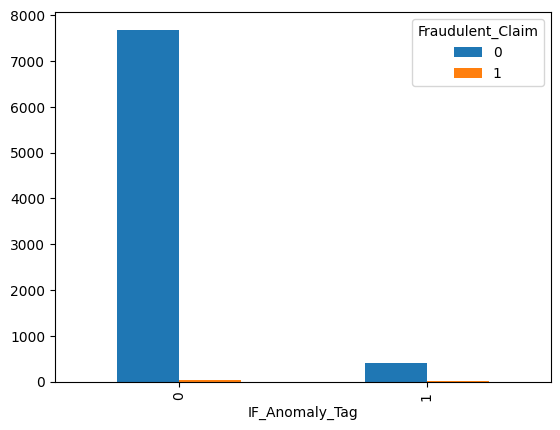

In [37]:
cross_tab.plot(kind='bar')
plt.show()

In [38]:
matching_rows = df_train[(df_train['IF_Anomaly_Tag'] == 1) & (df_train['Fraudulent_Claim'] == 1)]
matching_rows.head(5)

,Customer_Age,Annual_Income,Claim_History,Fraudulent_Claim,Premium_Amount,Claim_Amount,Risk_Score,Policy_Type_Health,Policy_Type_Home,Policy_Type_Life,Policy_Type_Travel,Gender_M,IF_Anomaly_Score,IF_Anomaly_Tag
39,76,0.115778,3,1,0.761005,0.875754,2,1,0,0,0,1,-1,1
358,67,0.352817,3,1,0.080399,0.898713,2,0,0,0,1,0,-1,1
743,24,0.298072,1,1,0.576815,0.504330,2,1,0,0,0,1,-1,1
1257,45,0.016022,4,1,0.049987,0.553208,2,0,0,0,1,0,-1,1
1449,25,0.066994,1,1,0.104554,0.976244,2,0,1,0,0,1,-1,1


In [39]:
total_anomalies = df_train[df_train['IF_Anomaly_Tag'] == 1].shape[0]
total_fraudulent = df_train[df_train['Fraudulent_Claim'] == 1].shape[0]

if total_anomalies > 0 and total_fraudulent > 0:
    print(f"\nPercentage of anomalies that are fraudulent: {len(matching_rows) / total_anomalies * 100:.2f}%")



Percentage of anomalies that are fraudulent: 1.97%


In [40]:
# This 1.97% overlap rate between anomalies and fraudulent claims provides valuable insights:

# Only a small portion (1.97%) of the data points flagged as anomalies by Isolation Forest correspond to actual fraudulent claims
# The vast majority of anomalies detected are not fraudulent claims

# Hence, we use the data without Anomaly Tag by the Isolation Forest.

### Heatmap

In [41]:
df_corr = df_train.drop(['IF_Anomaly_Score','IF_Anomaly_Tag'], axis = 1)
corr = df_corr.corr()

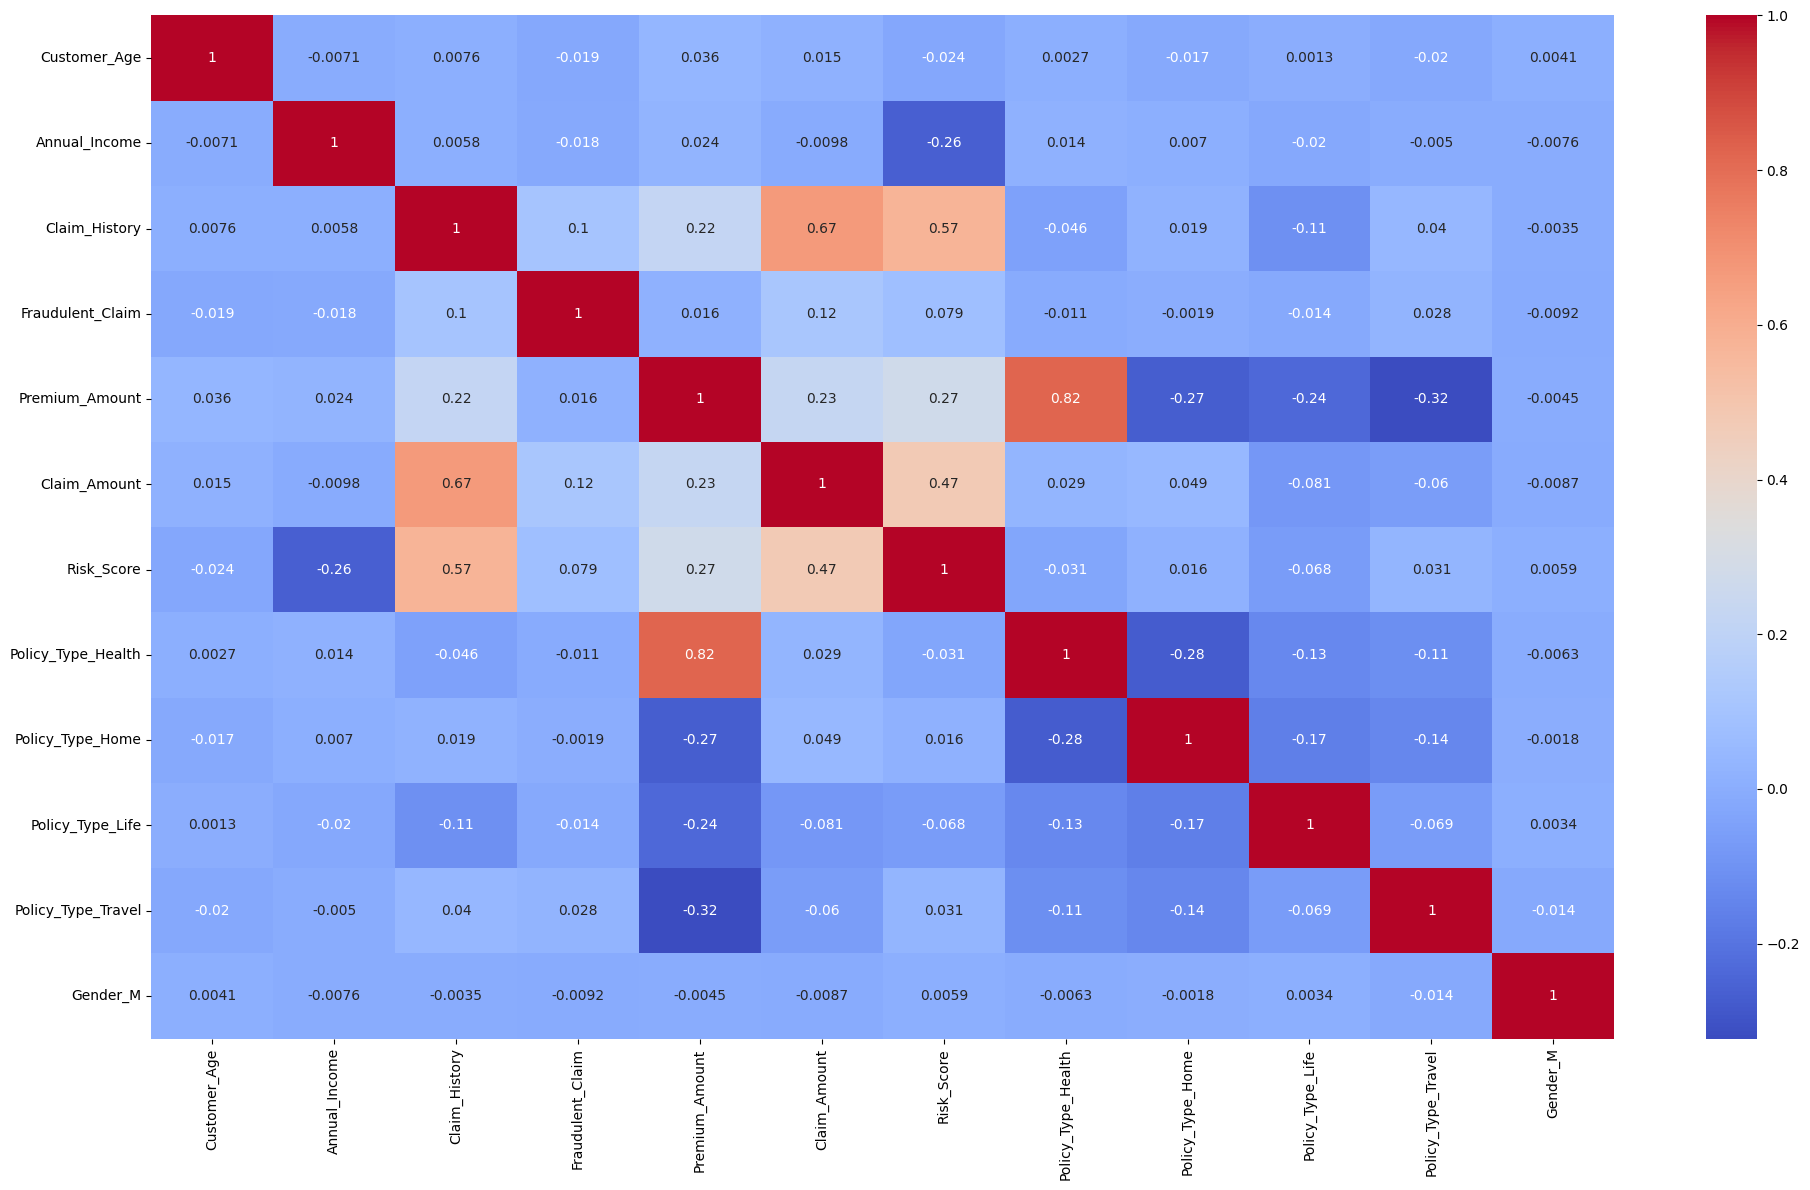

In [42]:
plt.figure(figsize=(20,12))
sns.heatmap(corr, annot=True, cmap = 'coolwarm')
plt.tight_layout()
plt.show()

# Model Training - Regression - Claim Prediction

In [43]:
X = df_train.drop(['IF_Anomaly_Score','IF_Anomaly_Tag','Claim_Amount'], axis= 1)

In [44]:
y = df_train['Claim_Amount']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.30, random_state=10)

# shape of the X_train, X_test, y_train, y_test features
print("x train: ",X_train.shape)
print("x test: ",X_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (5686, 11)
x test:  (2438, 11)
y train:  (5686,)
y test:  (2438,)


In [46]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score = model_lr.score(X_train, y_train)
train_score, test_score

(0.48289866959532846, 0.45236292428738967)

In [47]:
model_rg = Ridge(alpha=1)
model_rg.fit(X_train, y_train)
test_score = model_rg.score(X_test, y_test)
train_score = model_rg.score(X_train, y_train)
train_score, test_score

(0.48289392648621565, 0.45230335172446)

In [48]:
# Both the train and test score are less when using Linear and Ridge Regression. Hence, we can use XGBoost model.

In [50]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
train_score = model_xgb.score(X_train, y_train)
test_score = model_xgb.score(X_test, y_test)
train_score, test_score

(0.9562410134065833, 0.6873284111201841)

In [233]:
# The train score is high when compared to test score, the model is overfitting.

In [51]:
param_grid = {
    'max_depth': [3, 4],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [52]:
# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model_xgb ,
    param_distributions=param_grid,
    n_iter=5,
    scoring='r2',  
    cv=5,  # 5-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

In [53]:
# Fit the random search to the data
random_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = random_search.best_params_

print(f"Best parameters: {best_params}")


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 1.0}


In [54]:
model_xgb = XGBRegressor(subsample = 1.0, n_estimators = 200, max_depth = 3, learning_rate = 0.05, colsample_bytree = 1.0, reg_lambda =5, reg_alpha = .5)
scores = cross_val_score(model_xgb, X_train, y_train, cv=5, scoring='r2')
scores

array([0.74184376, 0.73286698, 0.74298844, 0.74442458, 0.74962971])

In [55]:
model_xgb.fit(X_train, y_train)
train_score = model_xgb.score(X_train, y_train)
test_score = model_xgb.score(X_test, y_test)
train_score, test_score

(0.7648676434799695, 0.7452164510680155)

In [56]:
y_pred = model_xgb.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f'Test RMSE: {rmse:.2f}')
print(f'Test R² Score: {r2:.4f}')


Test RMSE: 0.13
Test R² Score: 0.7452


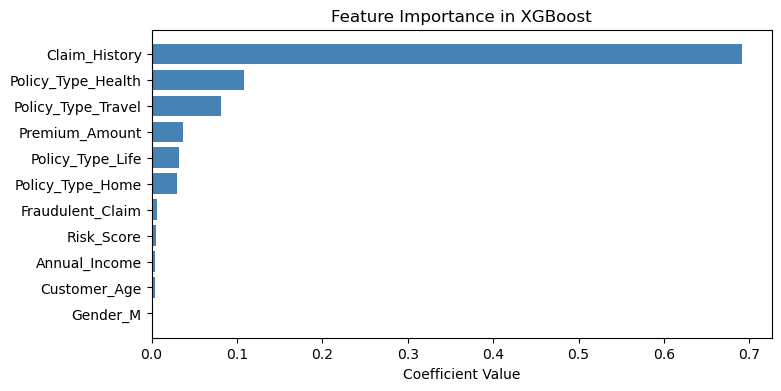

In [255]:
feature_importance = model_xgb.feature_importances_

coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns = ['Coefficients'])

coef_df = coef_df.sort_values(by = 'Coefficients', ascending=True)

plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBoost')
plt.show()

In [256]:
### Error Analysis

In [257]:
residuals = y_pred - y_test
residuals_pct = (residuals/y_test)*100

results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'diff': residuals,
    'diff_pct': residuals_pct})

results_df.head()

,actual,predicted,diff,diff_pct
638,0.000000,-0.013175,-0.013175,-inf
2536,0.000000,-0.000261,-0.000261,-inf
1989,0.518899,0.469139,-0.049760,-9.589576
3730,0.000000,-0.006480,-0.006480,-inf
899,0.000000,-0.000391,-0.000391,-inf


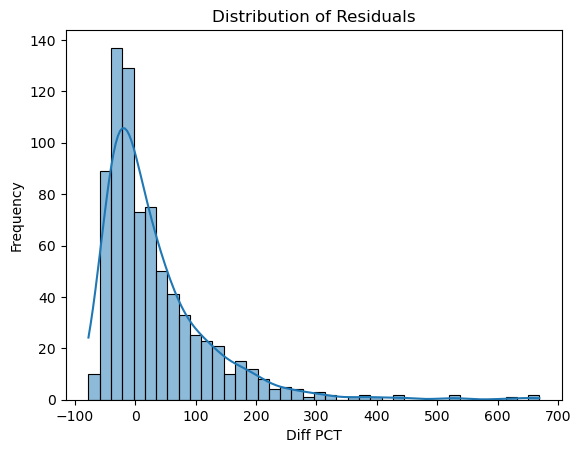

In [258]:
sns.histplot(results_df['diff_pct'], kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Diff PCT')
plt.ylabel('Frequency')
plt.show()

In [57]:
# Random Forest Regressor

In [60]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


# Random search of parameters, using 5 fold cross validation, 

rf_random = RandomizedSearchCV(estimator = RandomForestRegressor(), param_distributions = random_grid,
                               scoring='r2', n_iter = 6, cv = 5, 
                               verbose=1, random_state=42, n_jobs = 1)
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=6, n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='r2', verbose=1)

In [61]:
bestmodel = rf_random.best_estimator_
rf_random.best_params_

{'n_estimators': 300,
 'min_samples_split': 100,
 'min_samples_leaf': 5,
 'max_depth': 25}

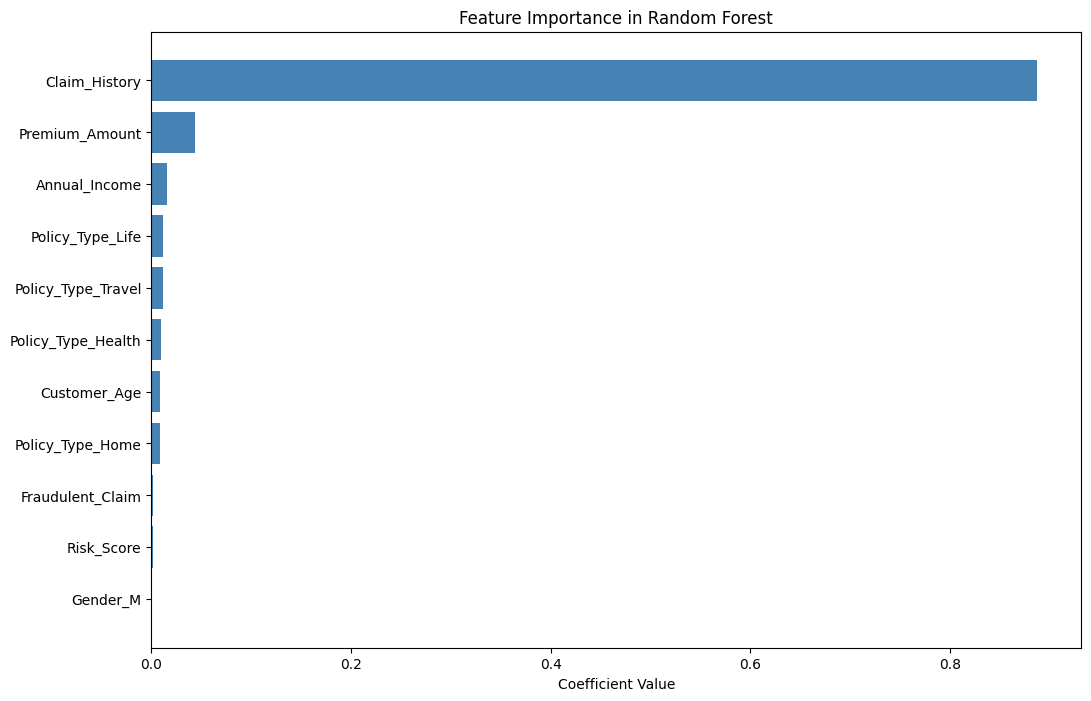

In [62]:
feature_importance = bestmodel.feature_importances_

random_df = pd.DataFrame(feature_importance, index=X_train.columns, columns = ['Coefficients'])

random_df = random_df.sort_values(by = 'Coefficients', ascending=True)

plt.figure(figsize=(12, 8))
plt.barh(random_df.index, random_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Random Forest')
plt.show()

In [63]:
y_pred = rf_random.predict(X_test)

In [64]:
print(r2_score(y_test, y_pred))

0.7434757219772044


# Export the XGBRegressor model

In [260]:
from joblib import dump

dump(model_xgb, "artifacts/model.joblib")
scaler_with_cols = {
    'scaler': scaler,
    'cols_to_scale': cols_to_scale
}
dump(scaler_with_cols, "artifacts/scaler_rest.joblib")

['artifacts/scaler_rest.joblib']

In [107]:
model1_data = {
    'model': model_xgb,
    'features': X_train.columns,
    'scaler': scaler,
    'cols_to_scale': cols_to_scale
}
dump(model1_data, 'artifacts/model1_data.joblib')

['artifacts/model1_data.joblib']

# Model Training - Classification - Risk Prediction

In [74]:
df_train.head(3)

,Customer_Age,Annual_Income,Claim_History,Fraudulent_Claim,Premium_Amount,Claim_Amount,Risk_Score,Policy_Type_Health,Policy_Type_Home,Policy_Type_Life,Policy_Type_Travel,Gender_M,IF_Anomaly_Score,IF_Anomaly_Tag
0,56,0.509122,0,0,0.074871,0.0,0,0,0,1,0,1,1,0
1,69,0.126961,0,0,0.218776,0.0,1,0,0,0,0,1,1,0
3,32,0.131683,0,0,0.116027,0.0,0,0,0,0,0,1,1,0


In [128]:
X = df_train.drop(['IF_Anomaly_Score','IF_Anomaly_Tag','Risk_Score'], axis= 1)
y = df_train['Risk_Score']

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.30, random_state=10)

# shape of the X_train, X_test, y_train, y_test features
print("x train: ",X_train.shape)
print("x test: ",X_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (5686, 11)
x test:  (2438, 11)
y train:  (5686,)
y test:  (2438,)


In [78]:
# Logistic Regression

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.68      0.79      0.73      1008
           1       0.54      0.51      0.52       900
           2       0.76      0.60      0.67       530

    accuracy                           0.64      2438
   macro avg       0.66      0.63      0.64      2438
weighted avg       0.65      0.64      0.64      2438



C:\Users\Harish\anaconda3\envs\DeepLearning\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [79]:
# Random Forest Classifier

rfmodel = RandomForestClassifier()
rfmodel.fit(X_train, y_train)

y_pred = rfmodel.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1008
           1       0.72      0.68      0.70       900
           2       0.81      0.82      0.81       530

    accuracy                           0.78      2438
   macro avg       0.78      0.79      0.78      2438
weighted avg       0.78      0.78      0.78      2438



In [80]:
# XGBClassifier

xgbmodel = XGBClassifier()
xgbmodel.fit(X_train, y_train)

y_pred = xgbmodel.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1008
           1       0.72      0.67      0.69       900
           2       0.80      0.84      0.82       530

    accuracy                           0.78      2438
   macro avg       0.78      0.79      0.78      2438
weighted avg       0.78      0.78      0.78      2438



In [84]:
### Randomized Search CV for XGBoost

# Define parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.15, 0.2, 0.25, 0.3],
    'reg_alpha': [1.0, 5.0, 10.0],  # L1 regularization term
    'reg_lambda': [1.0, 5.0, 10.0]  # L2 regularization term
}

xgb = XGBClassifier()

random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist, n_iter=100,
                                   scoring='f1', cv=5, verbose=1, n_jobs=-1, random_state=42)

random_search.fit(X_train, y_train)

# Print the best parameters and best score
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\Harish\anaconda3\envs\DeepLearning\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters: {'reg_lambda': 5.0, 'reg_alpha': 10.0, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1}
Best Score: nan
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1008
           1       0.77      0.65      0.70       900
           2       0.80      0.85      0.82       530

    accuracy                           0.80      2438
   macro avg       0.79      0.80      0.79      2438
weighted avg       0.79      0.80      0.79      2438



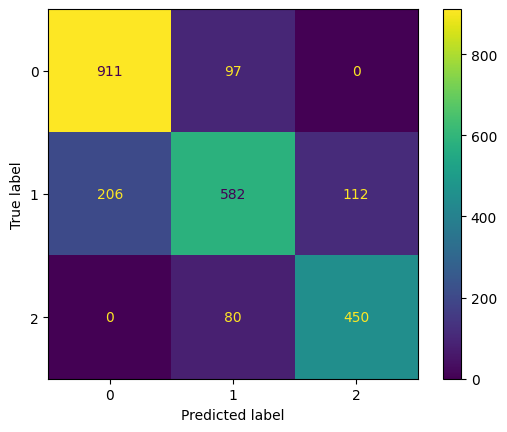

In [95]:
# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# Plot and save the confusion matrix
fig, ax = plt.subplots()
disp.plot(ax=ax)
plt.show()

In [97]:
# ROC_AUC Score:

# Multiclass ROC AUC (macro average)
y_score = best_model.predict_proba(X_test)
score = roc_auc_score(y_test, y_score, multi_class='ovr', average='macro')
print(f"ROC AUC Score (macro, OVR): {score:.4f}")


ROC AUC Score (macro, OVR): 0.9428


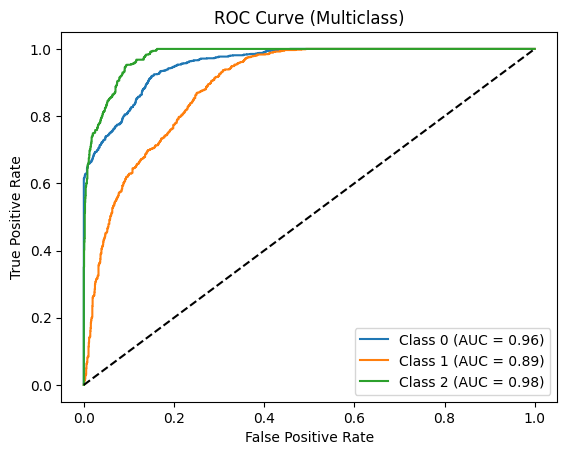

In [131]:
# ROC_CURVE
classes = [0, 1, 2]
y_test_bin = label_binarize(y_test, classes=classes)  # shape: (n_samples, n_classes)

for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Multiclass)')
plt.legend()
plt.show()


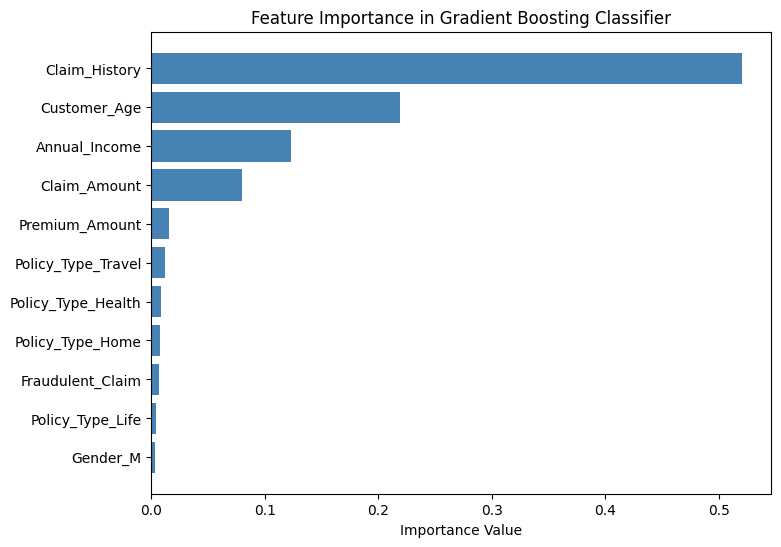

In [102]:
feature_importance = best_model.feature_importances_

# Create a DataFrame for easier handling
feature_importance_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Importance'])

# Sort the coefficients for better visualization
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

# Plotting
plt.figure(figsize=(8, 6))
plt.barh(feature_importance_df.index, feature_importance_df['Importance'], color='steelblue')
plt.xlabel('Importance Value')
plt.title('Feature Importance in Gradient Boosting Classifier')
plt.show()

In [105]:
X_train.columns

Index(['Customer_Age', 'Annual_Income', 'Claim_History', 'Fraudulent_Claim',
       'Premium_Amount', 'Claim_Amount', 'Policy_Type_Health',
       'Policy_Type_Home', 'Policy_Type_Life', 'Policy_Type_Travel',
       'Gender_M'],
      dtype='object')

In [88]:
X_test.columns

Index(['Customer_Age', 'Annual_Income', 'Claim_History', 'Fraudulent_Claim',
       'Premium_Amount', 'Claim_Amount', 'Policy_Type_Health',
       'Policy_Type_Home', 'Policy_Type_Life', 'Policy_Type_Travel',
       'Gender_M'],
      dtype='object')

In [89]:
X_test.head(2)

,Customer_Age,Annual_Income,Claim_History,Fraudulent_Claim,Premium_Amount,Claim_Amount,Policy_Type_Health,Policy_Type_Home,Policy_Type_Life,Policy_Type_Travel,Gender_M
638,22,0.287856,0,0,0.035994,0.0,0,0,0,1,1
2536,50,0.473572,0,0,0.349655,0.0,1,0,0,0,1


In [112]:
y_test

638     2
2536    0
1989    2
3730    0
899     0
       ..
853     0
8332    1
6382    0
4537    2
997     0
Name: Risk_Score, Length: 2438, dtype: int64

In [113]:
y_pred

array([ 1.5696875 , -0.07460137,  1.6083944 , ...,  0.35951418,
        1.5161102 , -0.00344463], dtype=float32)

In [103]:
cols_to_scale

['Annual_Income', 'Premium_Amount', 'Claim_Amount']

In [104]:
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=None, num_parallel_tree=None, ...)

# Export the XGBClassifier Model

In [106]:
from joblib import dump

model2_data = {
    'model': best_model,
    'features': X_train.columns,
    'scaler': scaler,
    'cols_to_scale': cols_to_scale
}
dump(model2_data, 'artifacts/model2_data.joblib')

['artifacts/model2_data.joblib']

# ML Flow - Classification

In [114]:
models = [
    (
        "XGBoosting Classifier",
        {'reg_lambda': 5.0, 'reg_alpha': 10.0, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1},
        XGBClassifier(), 
        (X_train, y_train),
        (X_test, y_test)
    ),
    (
        "Logistic Regression", 
        {"C": 0.86, "solver": 'liblinear', "max_iter" : 33},
        LogisticRegression(), 
        (X_train, y_train),
        (X_test, y_test)
    ),
    (
        "Random Forest Classifier", 
        {"max_depth": 14, "max_features": 'log2', "min_samples_leaf":6, "min_samples_split":3, "n_estimators":70},
        RandomForestClassifier(), 
        (X_train, y_train),
        (X_test, y_test)
    )
]

In [117]:
reports = []

for model_name, params, model, train_set, test_set in models:
    X_train = train_set[0]
    y_train = train_set[1]
    X_test = test_set[0]
    y_test = test_set[1]
    
    model.set_params(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    reports.append(report)

In [122]:
mlflow.set_experiment("Insurance_Risk_Detection")
mlflow.set_tracking_uri("http://localhost:5000")

for i, element in enumerate(models):
    model_name = element[0]
    params = element[1]
    model = element[2]
    report = reports[i]
    
    with mlflow.start_run(run_name=model_name):        
       # Log hyperparameters
       mlflow.log_params(params)
    
       # Log overall metrics
       mlflow.log_metrics({
          'accuracy': report['accuracy'],
          'f1_score_macro': report['macro avg']['f1-score'],
          'precision_macro': report['macro avg']['precision'],
          'recall_macro': report['macro avg']['recall']
        })
    
       # Log per-class metrics
       for class_label in ['0', '1', '2']:
          mlflow.log_metrics({
            f'precision_class_{class_label}': report[class_label]['precision'],
            f'recall_class_{class_label}': report[class_label]['recall'],
            f'f1_score_class_{class_label}': report[class_label]['f1-score']
        }) 

2025/04/30 15:23:27 INFO mlflow.tracking.fluent: Experiment with name 'Insurance_Risk_Detection' does not exist. Creating a new experiment.


🏃 View run XGBoosting Classifier at: http://localhost:5000/#/experiments/477377359313063387/runs/9617c580e6034039a01acc0ba2a1917d
🧪 View experiment at: http://localhost:5000/#/experiments/477377359313063387
🏃 View run Logistic Regression at: http://localhost:5000/#/experiments/477377359313063387/runs/e1c0f3d51a7a4b9389cabbdfe5bb2598
🧪 View experiment at: http://localhost:5000/#/experiments/477377359313063387
🏃 View run Random Forest Classifier at: http://localhost:5000/#/experiments/477377359313063387/runs/26faa0760b4e47a78d23734534b74f76
🧪 View experiment at: http://localhost:5000/#/experiments/477377359313063387


# MLFLow Regression

In [123]:
# Use the df_train dataframe to create new values of X and y for training regression models

X = df_train.drop(['IF_Anomaly_Score','IF_Anomaly_Tag','Claim_Amount'], axis= 1)
y = df_train['Claim_Amount']
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.30, random_state=10)

# shape of the X_train, X_test, y_train, y_test features
print("x train: ",X_train.shape)
print("x test: ",X_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (5686, 11)
x test:  (2438, 11)
y train:  (5686,)
y test:  (2438,)


In [124]:
models = [
    ("Linear Regression", 
        {'n_jobs':1, 'positive':False},
        LinearRegression(), 
        (X_train, y_train),
        (X_test, y_test)
    ),
    (
        "Random Forest Regressor", 
        {'n_estimators': 300, 'min_samples_split': 100, 'min_samples_leaf': 5, 'max_depth': 25},
        RandomForestRegressor(), 
        (X_train, y_train),
        (X_test, y_test)
    ),
    (
        "XGBRegressor",
        {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 1.0},
        XGBRegressor(), 
        (X_train, y_train),
        (X_test, y_test)
    )
]

In [125]:
reports = []

for model_name, params, model, train_set, test_set in models:
    X_train = train_set[0]
    y_train = train_set[1]
    X_test = test_set[0]
    y_test = test_set[1]
    
    model.set_params(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    r2 = r2_score(y_test,y_pred)
    reports.append((model_name,rmse,r2))

In [126]:
mlflow.set_experiment("Insurance Claim Prediction")
mlflow.set_tracking_uri("http://127.0.0.1:5000")

for i, element in enumerate(models):
    model_name = element[0]
    params = element[1]
    model = element[2]
    report = reports[i]
        
    with mlflow.start_run(run_name=model_name):        
        mlflow.log_params(params)
        mlflow.log_metrics({
            'RMSE': report[1],
            'R2': report[2]
        })  
        
        if "XGB" in model_name:
            mlflow.xgboost.log_model(model, "model")
        else:
            mlflow.sklearn.log_model(model, "model")  

2025/04/30 15:56:04 INFO mlflow.tracking.fluent: Experiment with name 'Insurance Claim Prediction' does not exist. Creating a new experiment.
2025/04/30 15:56:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Linear Regression at: http://127.0.0.1:5000/#/experiments/489447961176868989/runs/3322be7ad0b142478e6c3997fefc7ccd
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/489447961176868989


2025/04/30 15:56:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Random Forest Regressor at: http://127.0.0.1:5000/#/experiments/489447961176868989/runs/86df8b4cb5794e2596ceba8e1f01be46
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/489447961176868989


C:\Users\Harish\anaconda3\envs\DeepLearning\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [15:56:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/04/30 15:56:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBRegressor at: http://127.0.0.1:5000/#/experiments/489447961176868989/runs/fb24c89af52449e4a188e0124c1f107d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/489447961176868989
